In [1]:
import os, sys
import torch
import numpy as np
import torch.multiprocessing
import logging
from tqdm import tqdm
from metrics import evaluate_model_uncond
from utils.loggers import NeptuneLogger, PrintLogger, CompositeLogger
from models.model import ImagenTime
from models.sampler import DiffusionProcess
from utils.utils import save_checkpoint, restore_state, create_model_name_and_dir, print_model_params, \
    log_config_and_tags
from utils.utils_data import gen_dataloader
from utils.utils_args import parse_args_uncond

# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
torch.multiprocessing.set_sharing_strategy('file_system')

# if __name__ == '__main__':
import sys
sys.argv = ['run_unconditional.py', '--config', './configs/unconditional/fred_md.yaml']

args = parse_args_uncond()  # parse unconditional generation specific args
torch.random.manual_seed(args.seed)
np.random.default_rng(args.seed)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# main(args)

# model name and directory
name = create_model_name_and_dir(args)

#change saved model name and log_dir name
args.log_dir = f"./logs/{args.dataset}/model_check_{args.dataset}"
name = f"model_check_{args.dataset}"

logging.info(args)
logger = PrintLogger()

# log config and tags
log_config_and_tags(args, logger, name)

# set-up data and device
args.device = "cuda" if torch.cuda.is_available() else "cpu"
train_loader, test_loader = gen_dataloader(args)

/root/anaconda3/envs/ImagenTime/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


config/hyperparameters:
{'attn_resolution': [32, 16, 8],
 'batch_size': 32,
 'beta1': 1e-05,
 'betaT': 0.01,
 'ch_mult': [1, 2, 4, 4],
 'config': './configs/unconditional/fred_md.yaml',
 'dataset': 'fred_md',
 'delay': None,
 'deterministic': False,
 'diffusion_steps': 18,
 'ema': True,
 'ema_warmup': 100,
 'embedding': None,
 'epochs': 500,
 'hop_length': 23,
 'img_resolution': 16,
 'input_channels': 3,
 'learning_rate': 0.0003,
 'log_dir': './logs/fred_md/model_check_fred_md',
 'logging_iter': 100,
 'n_fft': 63,
 'neptune': False,
 'num_workers': 4,
 'nv': 5,
 'outfold_num': None,
 'percent': 100,
 'resume': False,
 'seed': 0,
 'seq_len': None,
 'tags': ['karras', 'unconditional'],
 'unet_channels': 128,
 'use_stft': True,
 'weight_decay': 1e-05}
config/name:
'model_check_fred_md'
tags:
['karras', 'unconditional']
tags:
['fred_md']
./data/long_range/fred_md.tsf


Fred_md time-series signal $x_t\in \mathbb{R}^D$ has $t$ samples with $D$ number of features

In [2]:
import matplotlib.pyplot as plt

In [3]:
data = []
for i, data_batch in enumerate(train_loader):
    data.append(data_batch[0])
c_data = torch.cat(data, dim=0)

In [4]:
import torchaudio.transforms as T
spec_data = torch.permute(c_data, (0, 2, 1))
spec = T.Spectrogram(n_fft=63,hop_length=23, center=True, power=None)
transformed_data = spec(spec_data)

In [5]:
c_data.shape

torch.Size([85, 728, 1])

In [6]:
import torch
import torch.nn.functional as F

pad = (0, 0, 0, 17)  # (last_dim_left, last_dim_right, time_left, time_right)
signal = F.pad(c_data, pad, mode='constant', value=0)

print(signal.shape)  # torch.Size([85, 745, 1])

torch.Size([85, 745, 1])


In [7]:
signal = signal.squeeze(-1)

Create dummy time-series signal $x_t\in \mathbb{R}^D$ has $t$ samples with $D$ number of features

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# num_features = 85
# num_samples = 728

# signal = np.random.randn(num_features, num_samples)

In [9]:
# pad_width = ((0, 0), (0, 17))
# signal = np.pad(signal, pad_width, mode='constant')

We split time-series signal into overlapping frames (abit like sliding window format). The formul is depicted as follows:

$T_{i,k}[m] = x_t^D[kh + m] $

where m is num_frames, w is frame_size and h is hop_size, k is number of frames.

In [10]:
num_features = signal.shape[0]

In [11]:
frame_size = 32 # Number of samples per frame
hop_size = 23 # Overlap Size

num_frames = (signal.shape[1] - frame_size) // hop_size + 1
frames = np.zeros((num_features, num_frames, frame_size))

for i in range(num_features):
    for j in range(num_frames):
            start = j * hop_size
            frames[i,j] = signal[i,start:start + frame_size]

In [69]:
# frames = np.pad(frames,pad_width=((0,0),(0,1),(0,0)),constant_values=0)
# frames = np.array(frames)

In [12]:
frames.shape

(85, 32, 32)

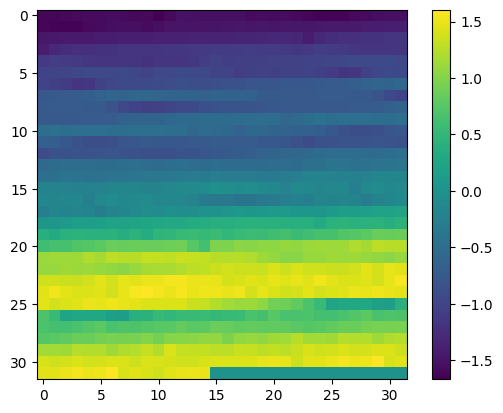

In [70]:
%matplotlib inline

plt.imshow(frames[5])
plt.colorbar()
plt.show()

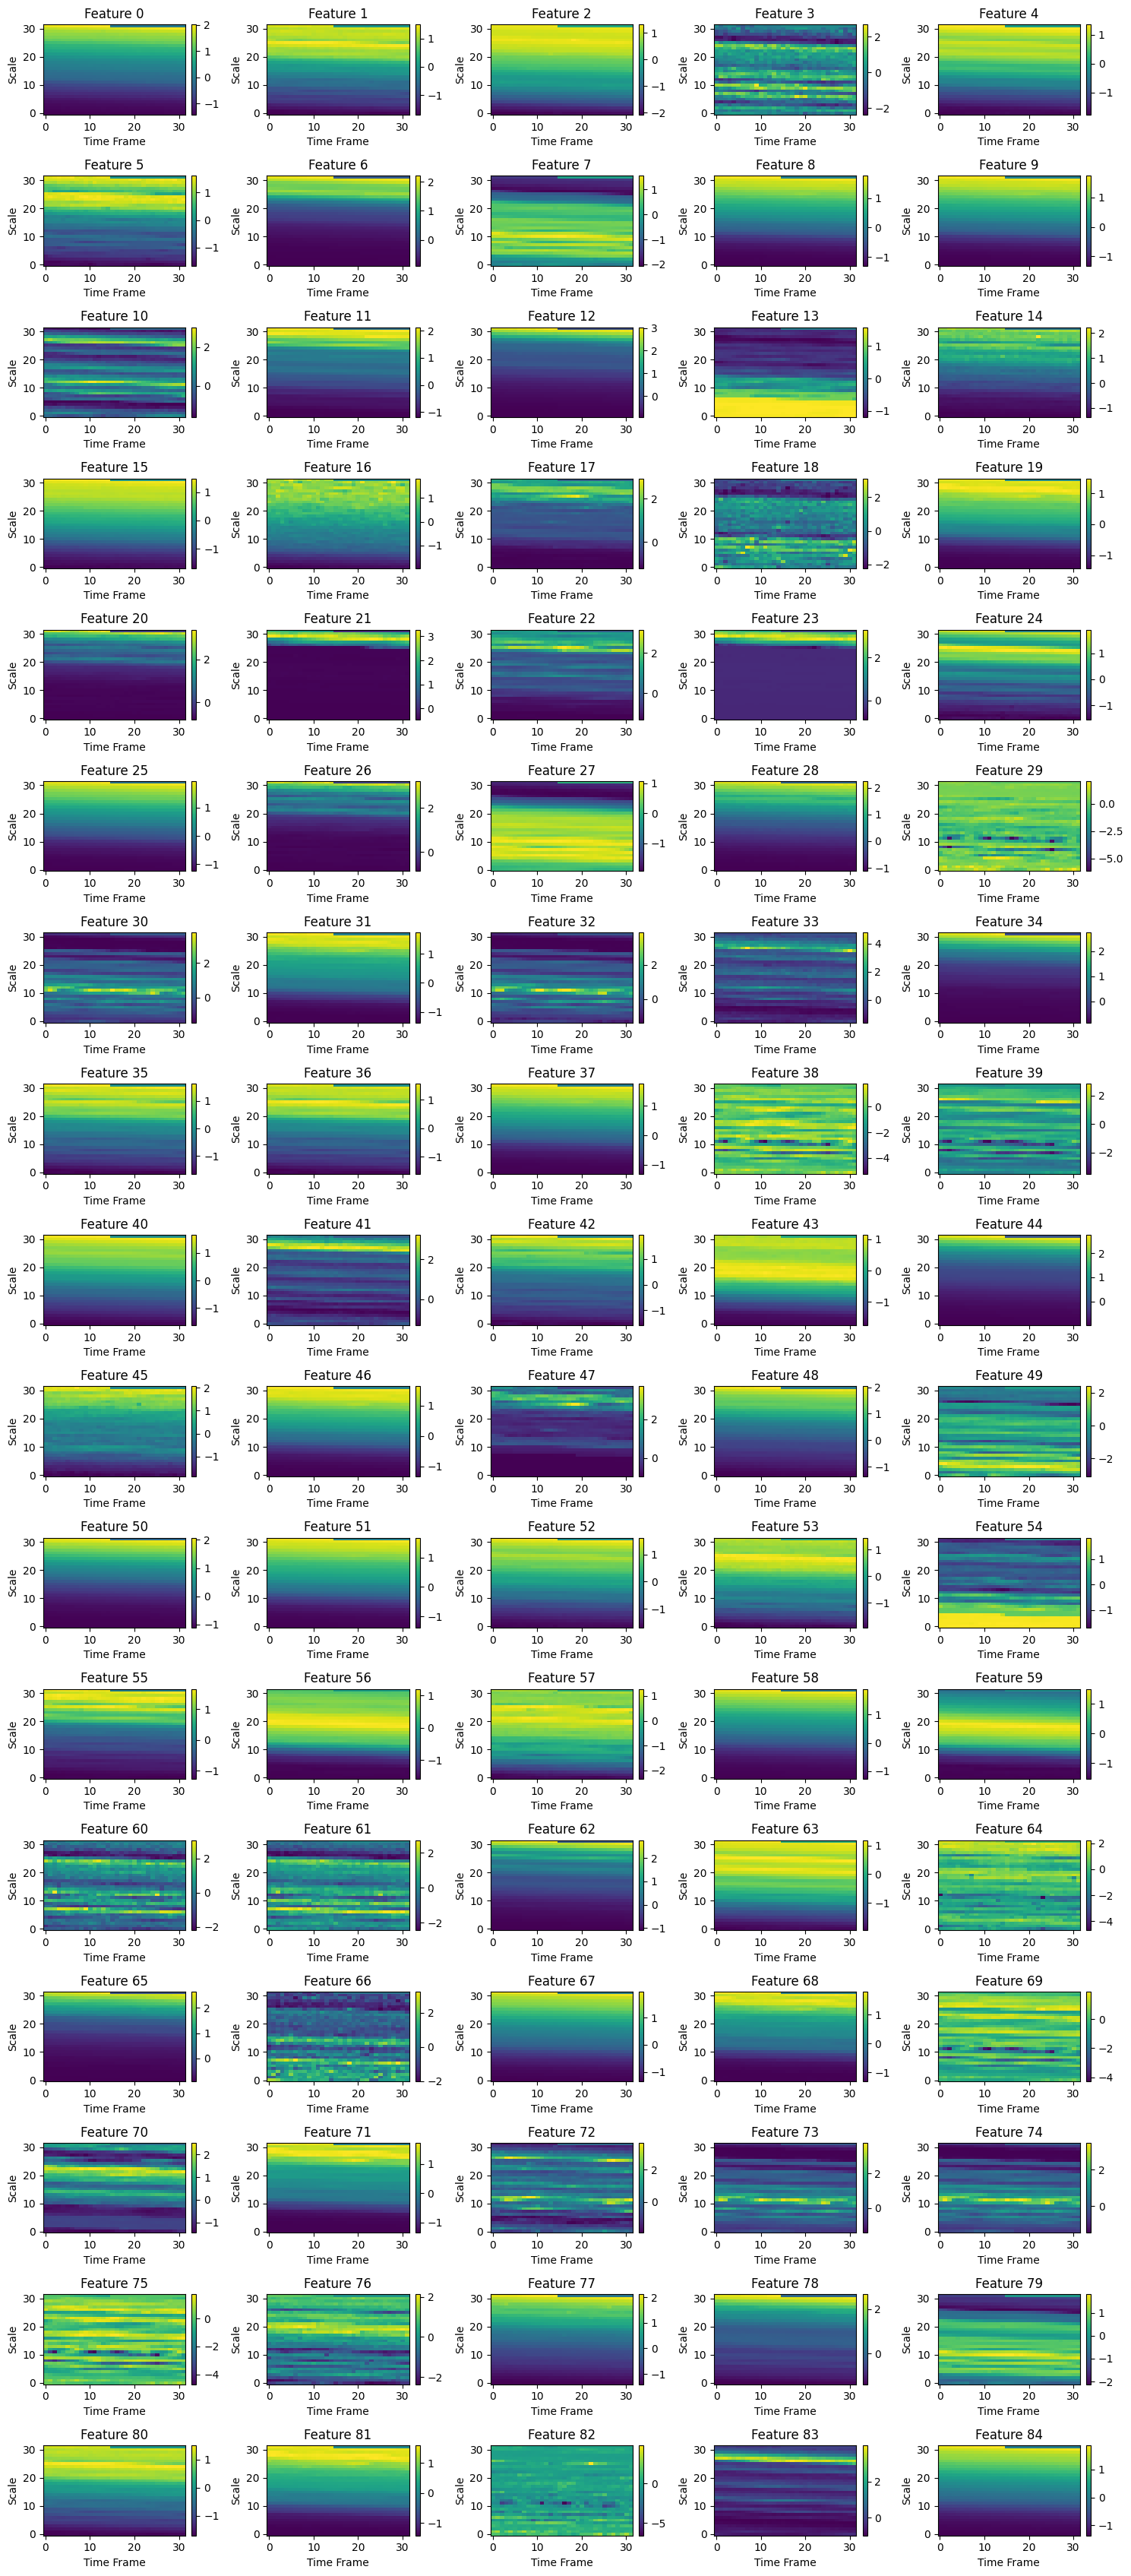

In [71]:
import math

cols = 5
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2))
axs = axs.flatten() 

for i in range(num_features):
    ax = axs[i]
    im = ax.imshow(frames[i], aspect='auto', origin='lower',)
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Time Frame')
    ax.set_ylabel('Scale')
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove any extra subplots (if grid has more slots than features)
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Here, we construct a forward shift matrix $A_k$ that model the $k$ temporal dependencies between samples in time-series frames, so that we can form a STFT-like spectogram with Graph Fourier Transform. 

where $A_k(i,j) = 1$ if $v_i \in next-k(v_j)$ where $j>i$

else $A_k(i,j) = 0$

The matrix $A_k$ could also be potentially improved with different type of matrix or extend to Laplcian matrix and learnable matrix.

In [72]:
k = 20
N = frame_size
A = np.zeros((N, N), dtype=int)

# loop for each node
for i in range(N):
    # consider the next k nodes for dependency. Not including itself.
    for j in range(i+1, min(N, i+k+1)):
        A[i, j] = 1

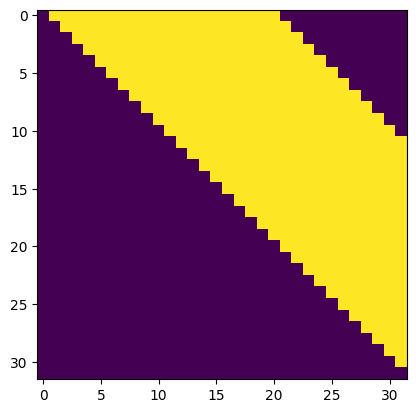

In [73]:
plt.imshow(A)
plt.show()

To obtin the real-valued graph Fourier basis, we compute SVD of our matrix $A_k$. 

This provide us $A_k = U \Sigma V^\top = \sum_{i=0}^I \mathbf{u}_i \, \sigma_i \, \mathbf{v}_i^\top $

In [74]:
U, sigma, Vh = np.linalg.svd(A, full_matrices=False)

In [75]:
U.shape

(32, 32)

To obtain the real-valued spectogram (time-graph frequency representation), we compute GFT encoder. where spectogram $S_D = U^\top x_f$



In [76]:
gft_spec = np.zeros_like(frames)

for i in range(num_features):
    for j in range(num_frames):
        Y = U.T @ frames[i,j]
        gft_spec[i, j] = Y

In [77]:
# gft_spec = np.pad(gft_spec,pad_width=((0,0),(0,1),(0,0)),constant_values=0)

In [78]:
gft_spec.shape

(85, 32, 32)

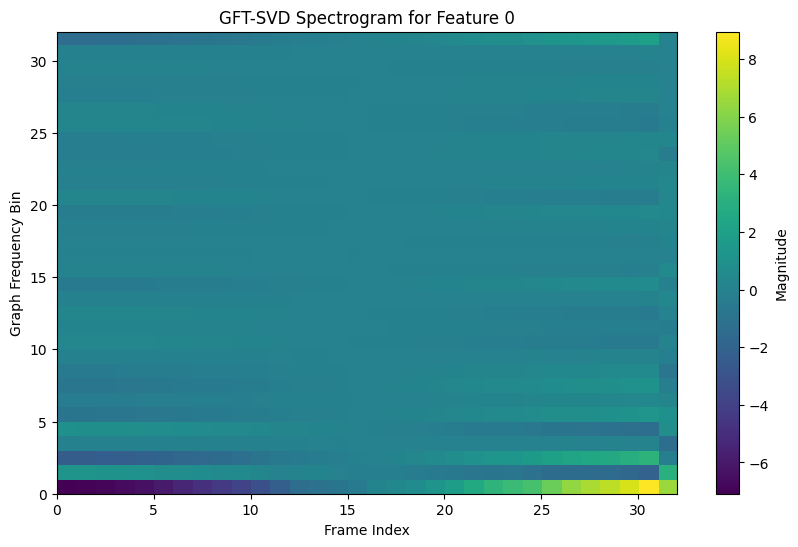

In [79]:
plt.figure(figsize=(10, 6))
plt.imshow(gft_spec[0].T, aspect='auto', origin='lower',
           extent=[0, num_frames, 0, frame_size])
plt.xlabel('Frame Index')
plt.ylabel('Graph Frequency Bin')
plt.title('GFT-SVD Spectrogram for Feature 0')
plt.colorbar(label='Magnitude')
plt.show()

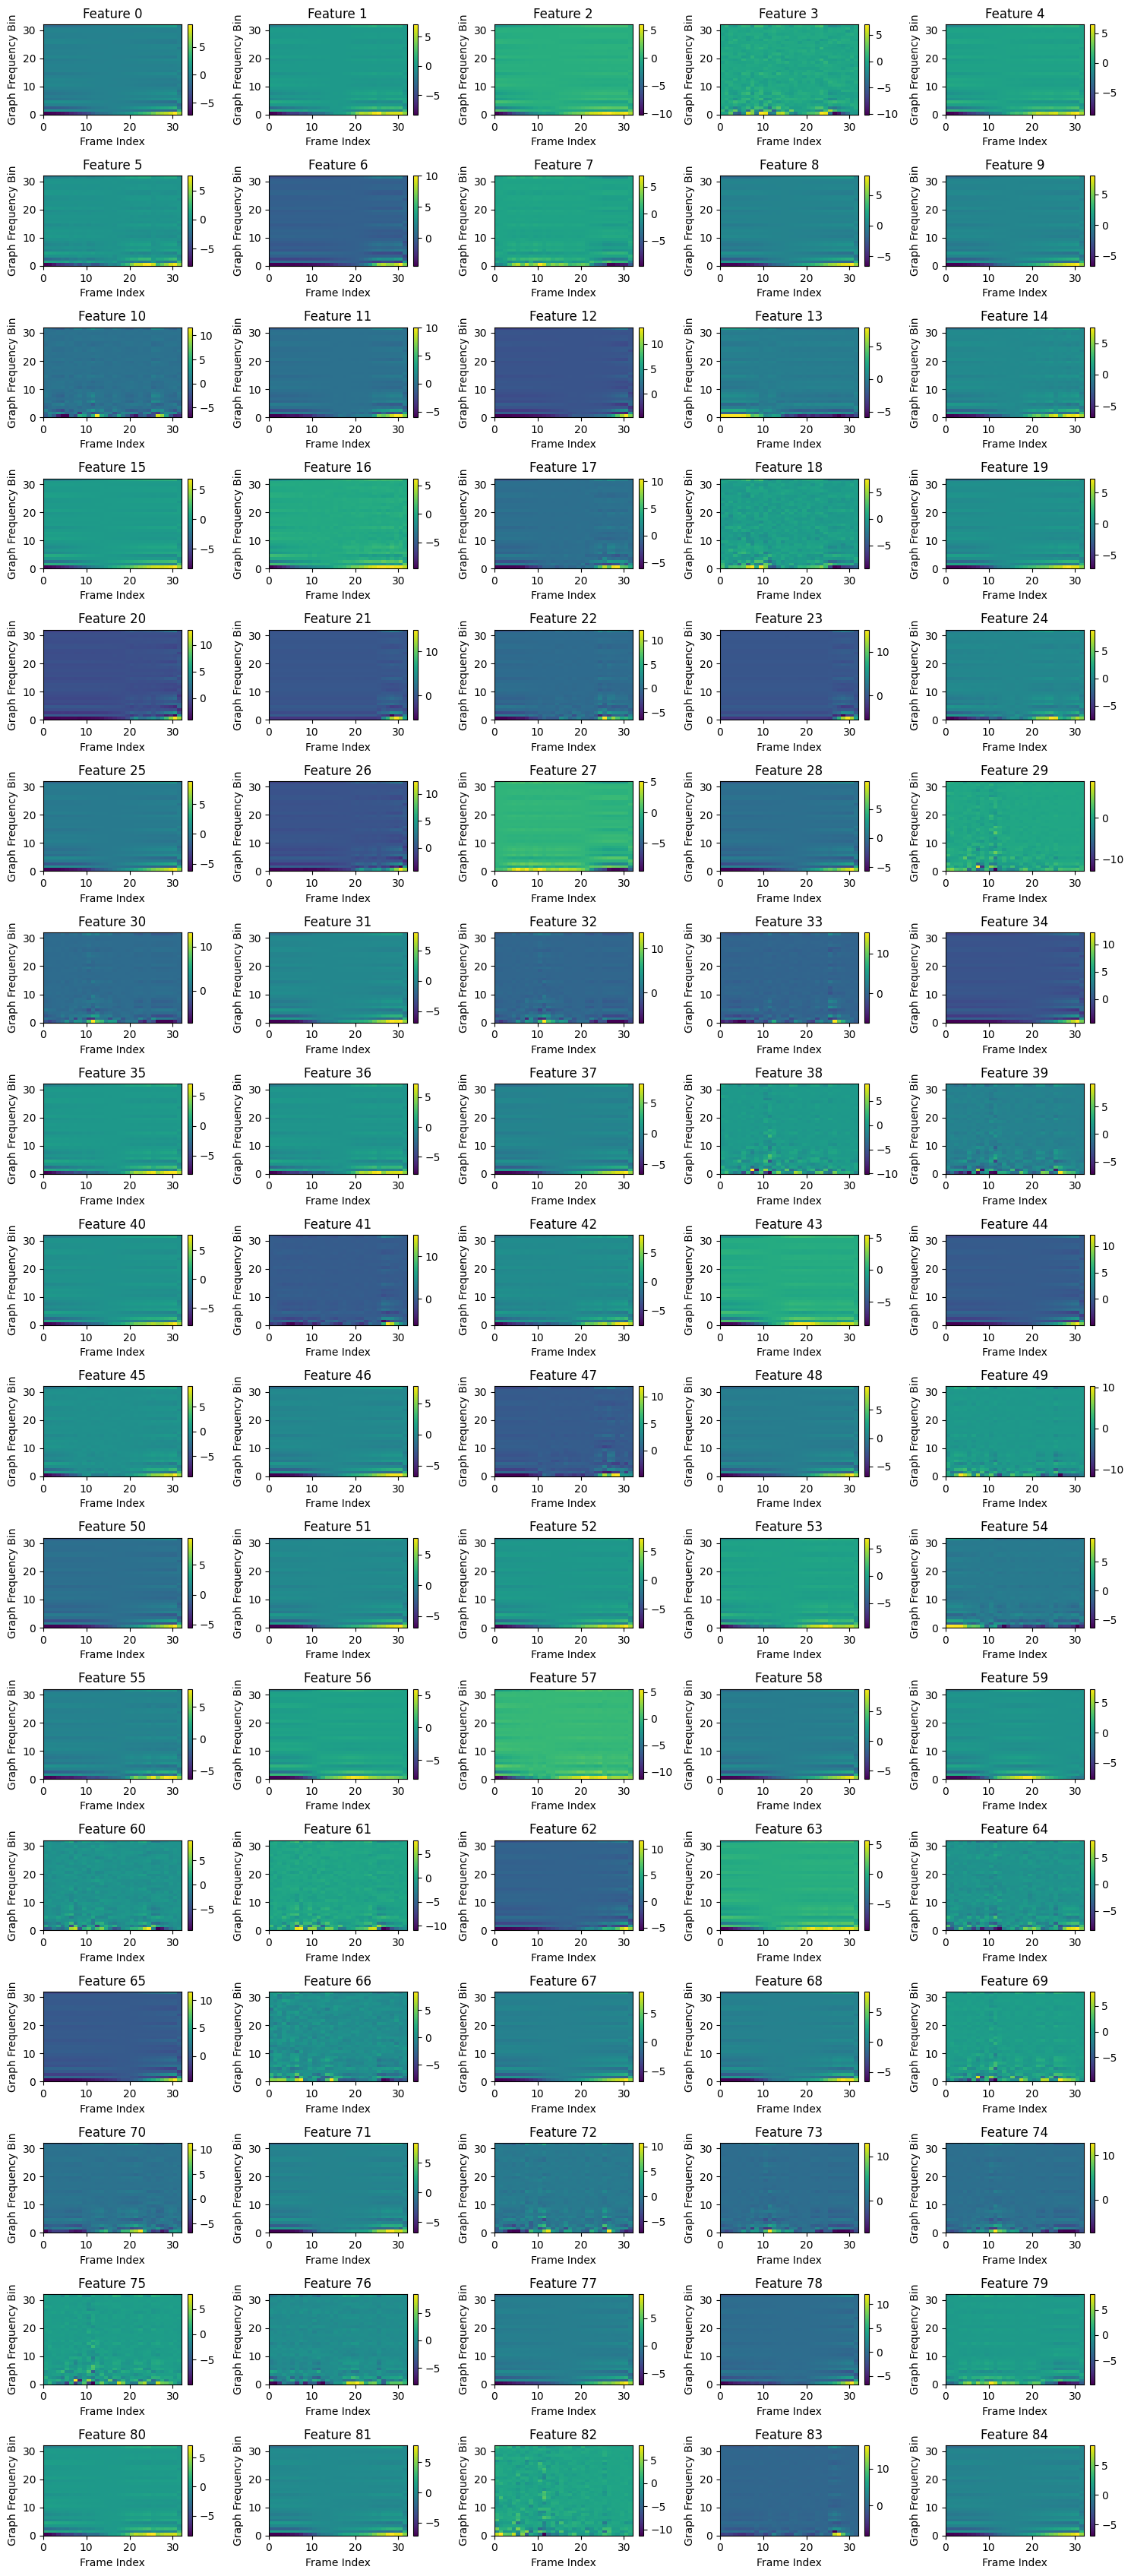

In [80]:
import math

cols = 5
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2))
axs = axs.flatten() 

for i in range(num_features):
    ax = axs[i]
    # Transpose so that x-axis represents time (frame index) and y-axis the frequency bin.
    im = ax.imshow(gft_spec[i].T, aspect='auto', origin='lower',
                   extent=[0, num_frames, 0, frame_size])
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Frame Index')
    ax.set_ylabel('Graph Frequency Bin')
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove any extra subplots (if grid has more slots than features)
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [99]:
transformed_data.real.shape

torch.Size([85, 1, 32, 32])

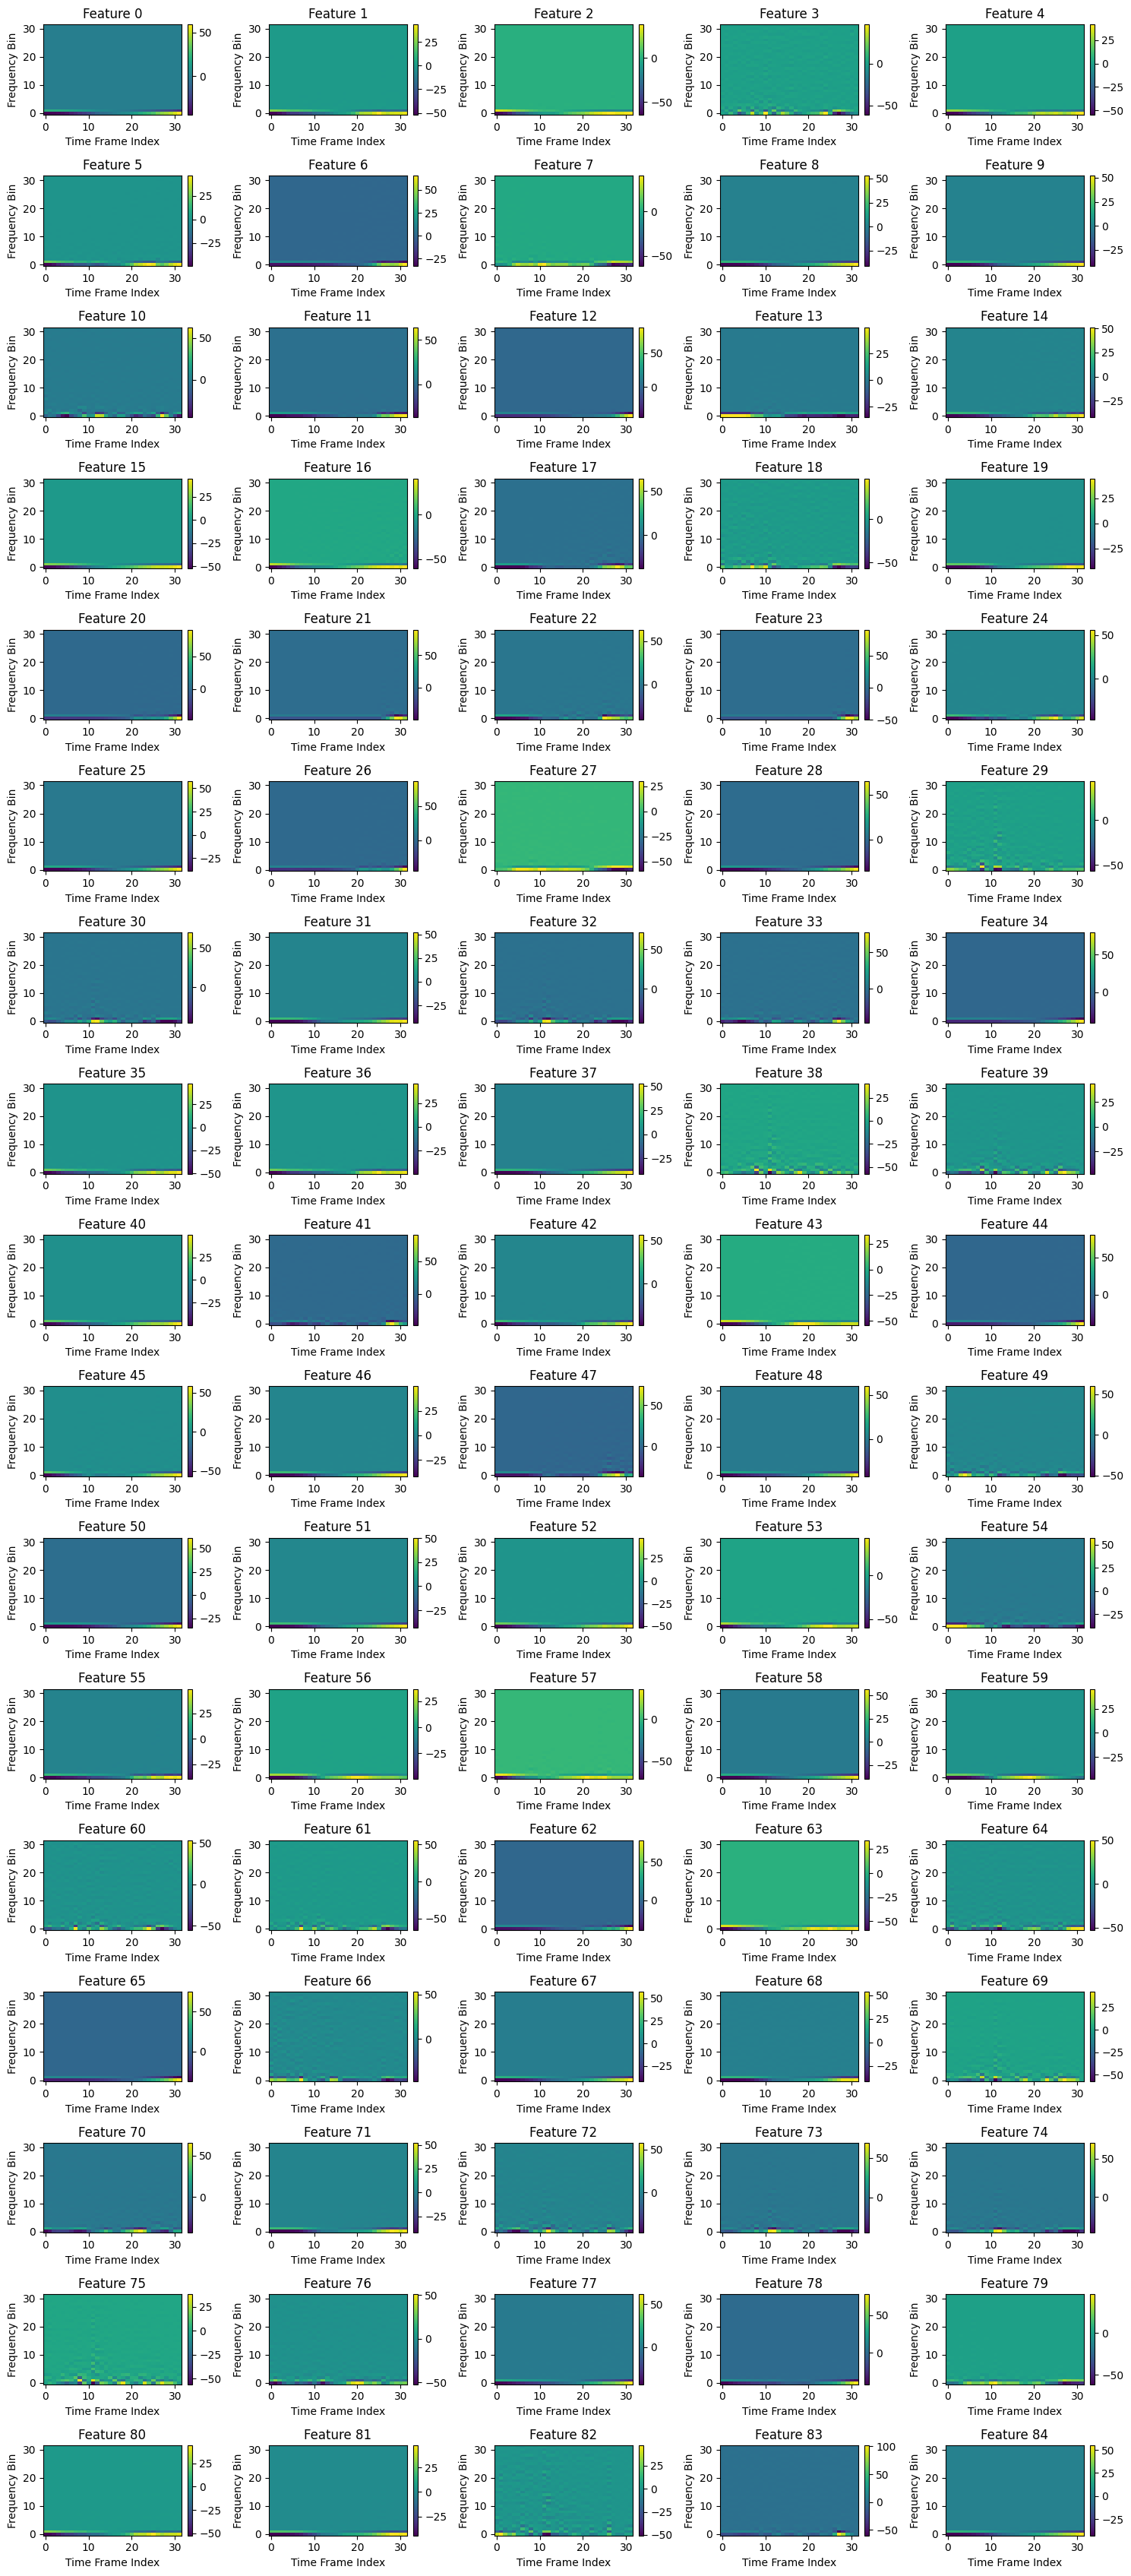

In [105]:
import math

cols = 5
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2))
axs = axs.flatten() 

for i in range(num_features):
    ax = axs[i]
    # Transpose so that x-axis represents time (frame index) and y-axis the frequency bin.
    im = ax.imshow(transformed_data.squeeze(1).cpu().numpy().real[i], aspect='auto', origin='lower')
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Time Frame Index')
    ax.set_ylabel('Frequency Bin')
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove any extra subplots (if grid has more slots than features)
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

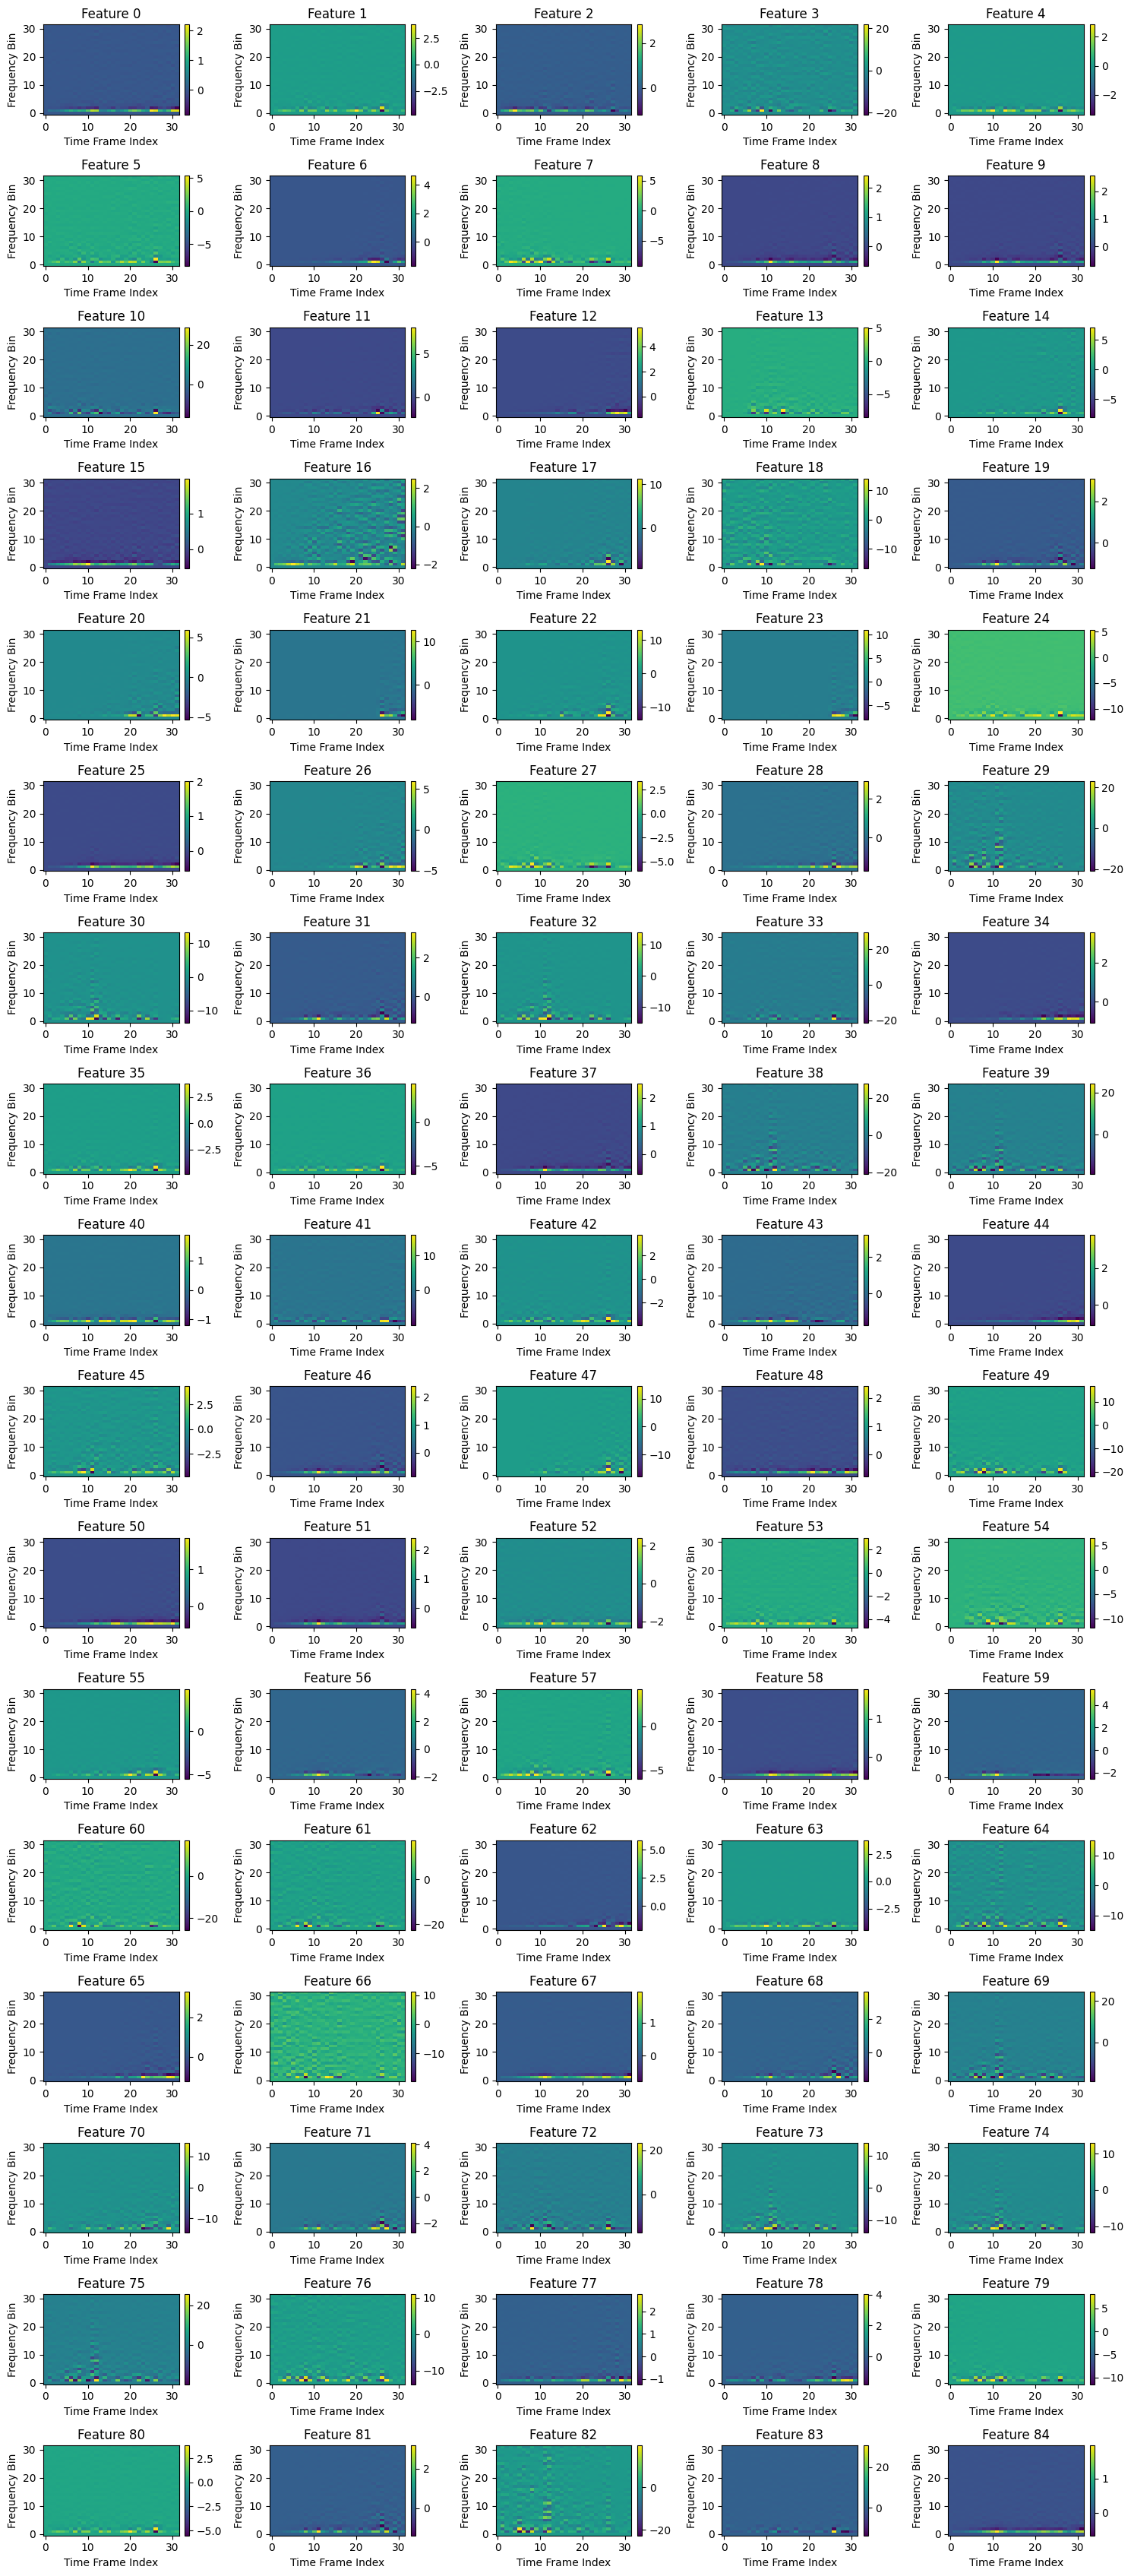

In [106]:
import math

cols = 5
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2))
axs = axs.flatten() 

for i in range(num_features):
    ax = axs[i]
    # Transpose so that x-axis represents time (frame index) and y-axis the frequency bin.
    im = ax.imshow(transformed_data.squeeze(1).cpu().numpy().imag[i], aspect='auto', origin='lower')
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Time Frame Index')
    ax.set_ylabel('Frequency Bin')
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove any extra subplots (if grid has more slots than features)
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

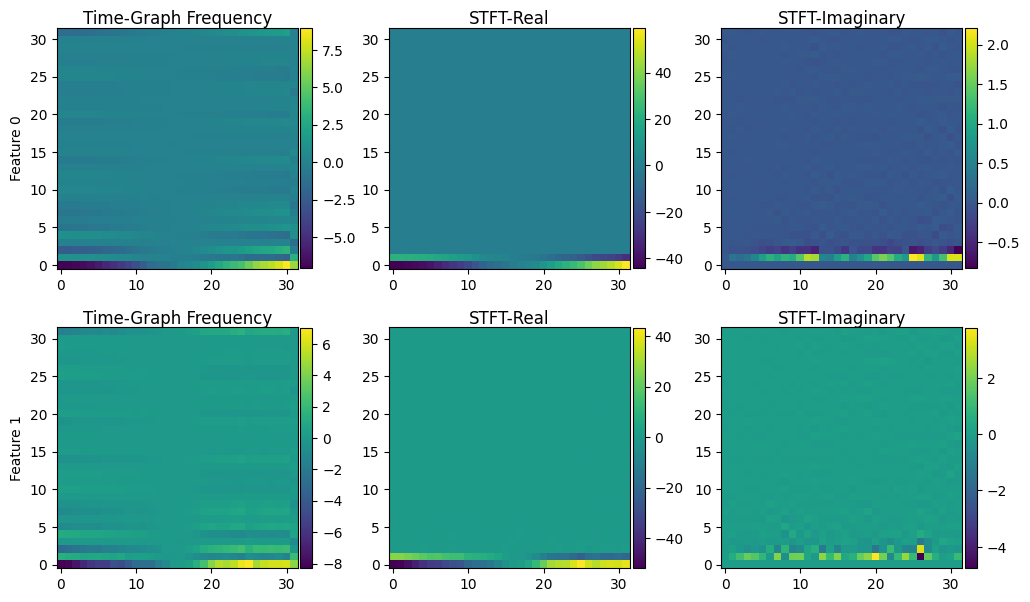

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

numrow = 2
for idx in range(numrow):  # 2 rows
    row_offset = idx * 3

    # === First column: Time-Graph Frequency ===
    ax1 = plt.subplot(numrow, 3, row_offset + 1)
    im1 = ax1.imshow(gft_spec[idx].T, origin='lower')
    ax1.set_title("Time-Graph Frequency", pad=2)
    ax1.set_ylabel(f"Feature {idx}")  # Label only on first column
    plt.colorbar(im1, ax=ax1, fraction=0.047, pad=0.01)

    # === Second column: STFT-Real ===
    ax2 = plt.subplot(numrow, 3, row_offset + 2)
    im2 = ax2.imshow(transformed_data.squeeze(1).cpu().numpy().real[idx], origin='lower')
    ax2.set_title("STFT-Real", pad=2)
    plt.colorbar(im2, ax=ax2, fraction=0.047, pad=0.01)

    # === Third column: STFT-Imaginary ===
    ax3 = plt.subplot(numrow, 3, row_offset + 3)
    im3 = ax3.imshow(transformed_data.squeeze(1).cpu().numpy().imag[idx], origin='lower')
    ax3.set_title("STFT-Imaginary", pad=2)
    plt.colorbar(im3, ax=ax3, fraction=0.047, pad=0.01)

# Tight layout and spacing control
plt.subplots_adjust(
    left=0.05, right=0.97,
    top=0.75, bottom=0.05,
    wspace=0.3, hspace=0.15
)

plt.show()

We perform pixel normalization. scale from 0 to 1.

In [81]:
data = gft_spec
min_spec = np.min(data)
max_spec = np.max(data, 0)
numerator = data - np.min(data, 0)
denominator = np.max(data, 0) - np.min(data, 0)
norm_data = numerator / (denominator)

In [82]:
min_spec.shape

()

In [83]:
def MinMaxArgs(data,min,max):

    numerator = data - min
    denominator = max - min
    norm_data = numerator / (denominator)

    return norm_data


norm_gft_spec = MinMaxArgs(gft_spec,min_spec,max_spec)

scale to -1 to 1 

In [84]:
norm_gft_spec = (norm_gft_spec - 0.5) * 2

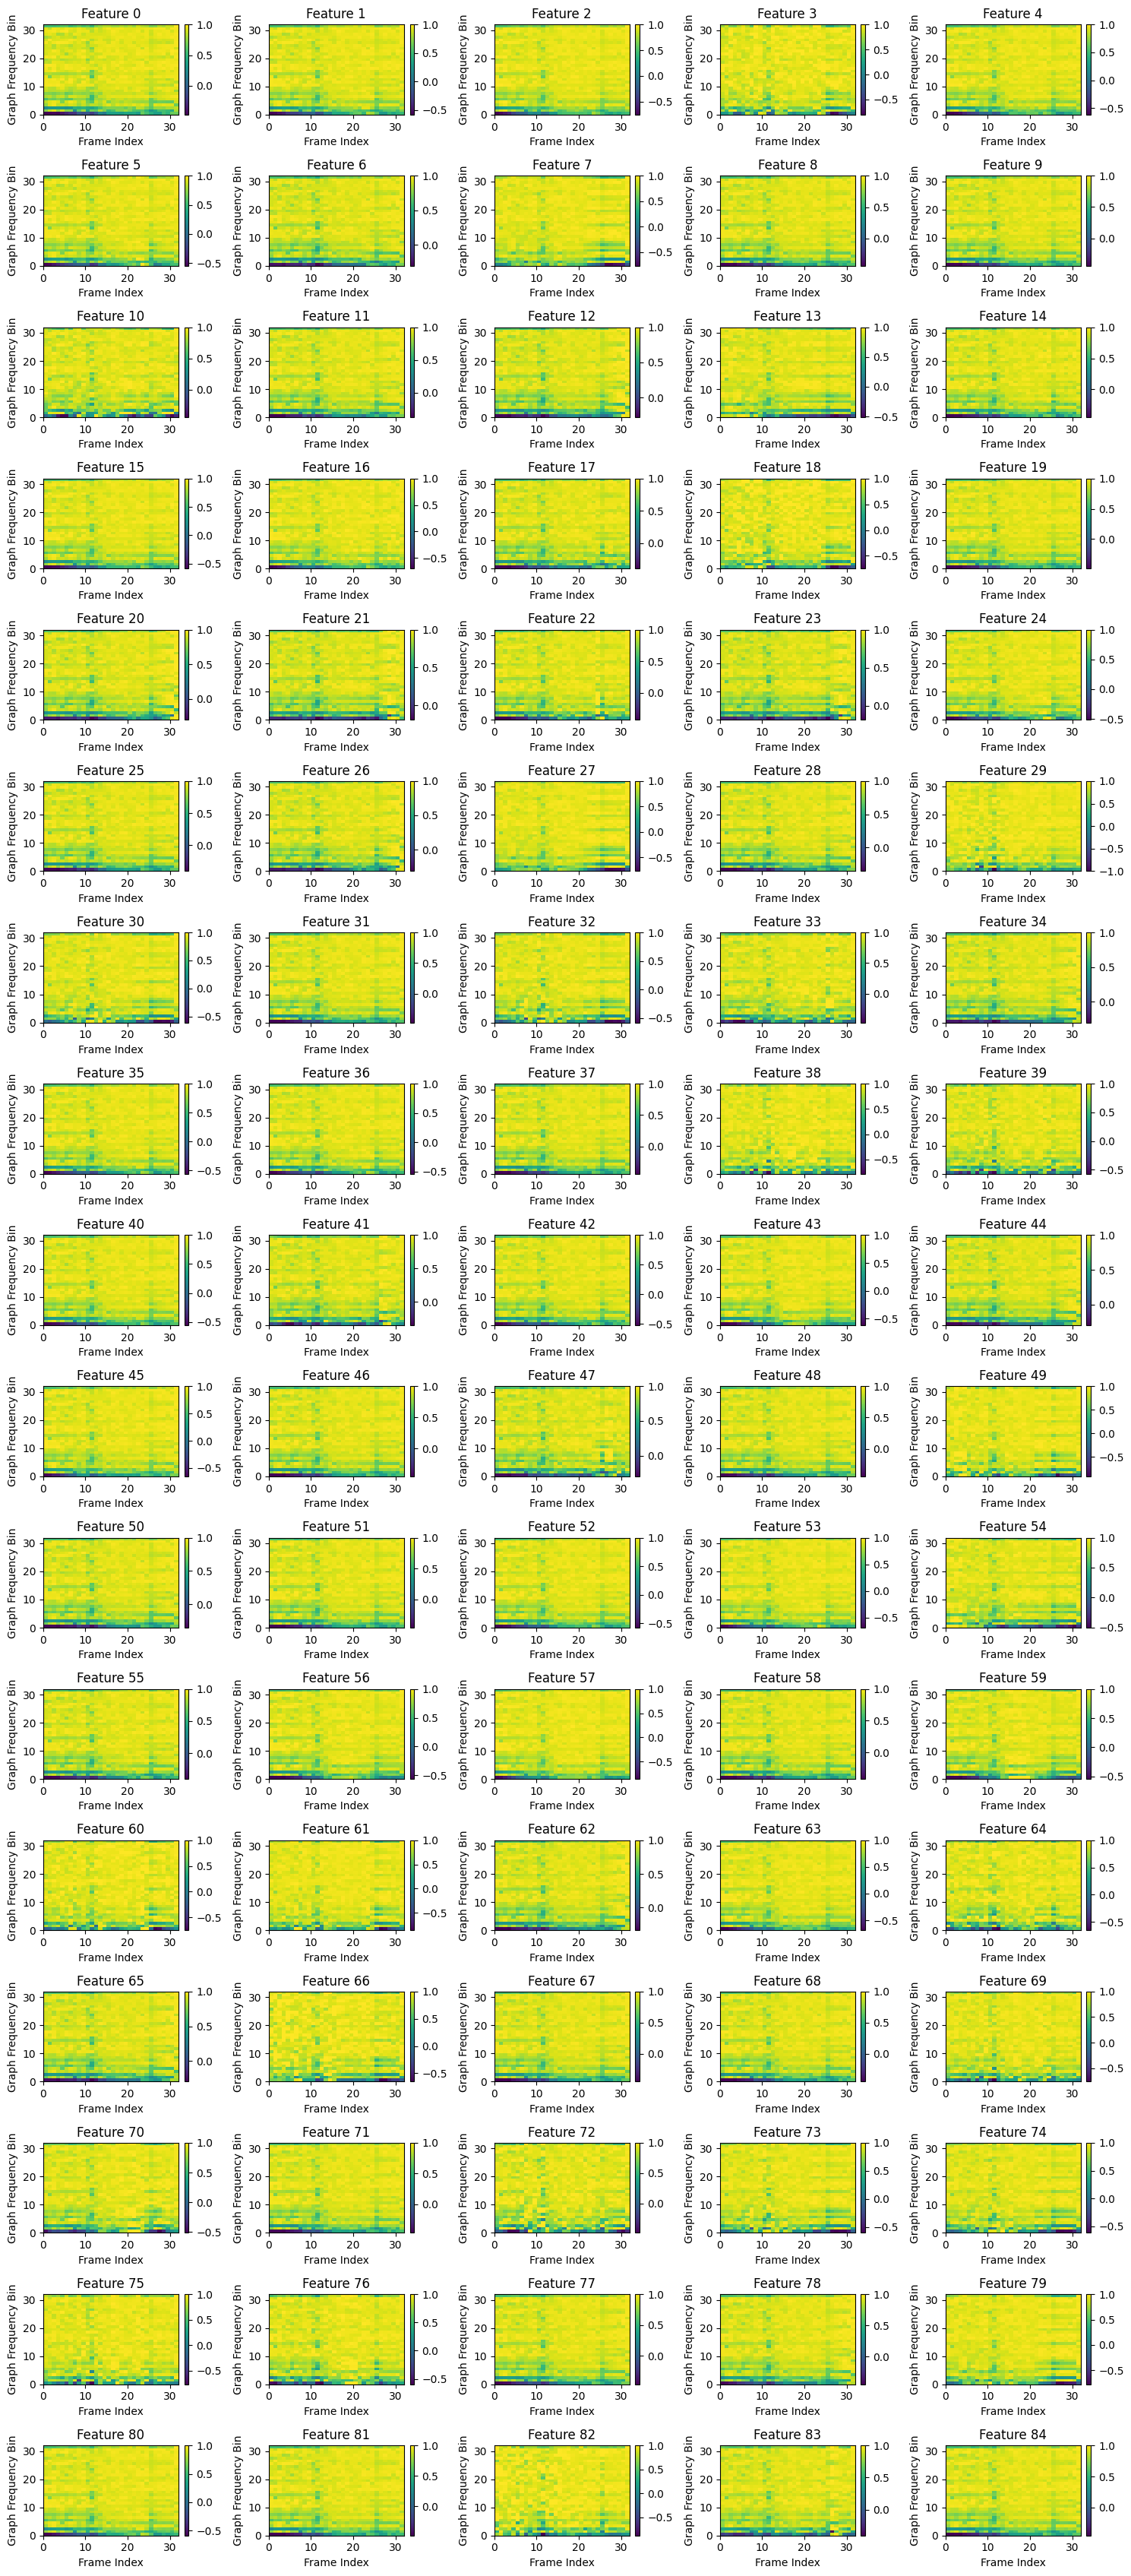

In [91]:
import math

cols = 5
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2))
axs = axs.flatten() 

for i in range(num_features):
    ax = axs[i]
    # Transpose so that x-axis represents time (frame index) and y-axis the frequency bin.
    im = ax.imshow(norm_gft_spec[i].T, aspect='auto', origin='lower',
                   extent=[0, num_frames, 0, frame_size])
    ax.set_title(f'Feature {i}')
    ax.set_xlabel('Frame Index')
    ax.set_ylabel('Graph Frequency Bin')
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Remove any extra subplots (if grid has more slots than features)
for j in range(num_features, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

we do inverse normalization from 0 to 1 to original

In [27]:
unnorm_norm_gft_spec = norm_gft_spec * (max_spec - min_spec) + min_spec

we do inverse normalization from -1 to 1 to original

In [86]:
unnorm_norm_gft_spec = ((norm_gft_spec / 2 + 0.5)) * (max_spec - min_spec) + min_spec

To reconstruct our to time-series frames, we compute iGFT-SVD. where $\hat{x}=U\hat{S_D}$, $\hat{S_D}$ is our predictions

In [87]:
gft_spec = unnorm_norm_gft_spec

In [88]:
reconstructed_frames = np.zeros_like(frames)
reconstruction_errors = np.zeros((num_features, num_frames))
for i in range(num_features):
    for j in range(num_frames):
        X_rec = U @ gft_spec[i,j]
        reconstructed_frames[i, j] = X_rec

To reconstruct time-series frames to time-series 1D signal. we compute reconstruction from time-series frames 

$x_i[n]= \frac{\sum_{i,k} [n - kh]}{\text{number of overlap frame}}  $

In [89]:
num_frames = reconstructed_frames.shape[1]
signal_length = hop_size * (num_frames - 1) + frame_size
reconstructed_signals = np.zeros((num_features, signal_length))

for j in range(num_features):
    # For each feature, initialize an overlap counter array.
    overlap_count = np.zeros(signal_length)
    for i in range(num_frames):
        start = i * hop_size
        # Add the i-th reconstructed frame for feature j.
        reconstructed_signals[j, start:start + frame_size] += reconstructed_frames[j, i]
        # Update the overlap counter for the corresponding indices.
        overlap_count[start:start + frame_size] += 1
    # Normalize by dividing by the overlap count to average overlapping samples.
    reconstructed_signals[j] /= np.maximum(overlap_count, 1)

In [90]:
np.linalg.norm(signal[:,:728]-reconstructed_signals[:,:728])

2.61787612125984e-13